# Setup


In [116]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [117]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [118]:
import torch
from pathlib import Path
from dataset import Video

# Create dataset
Creating data for input to the model is a little tricky. Details in the readme.

In [119]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/train') #in jpg format, from included script
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json') # in json format, from included script

In [4]:
from dataset_import import get_training_set, get_validation_set, get_test_set
from model import generate_model
class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    
input_args=Args()

In [5]:
from spatial_transforms2 import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms2 import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose

In [6]:
norm_value=255 #for rgb data

scale_step=0.84089 #for the kinetics dataset
scales = [1]
n_scales=5
for i in range(1, n_scales):
    scales.append(scales[-1] * scale_step)
    
sample_size=112 # default for kinetics
sample_duration=4 # my choosen window size
norm_method = Normalize([110.636/norm_value, 103.1606/norm_value, 96.29/norm_value], 
                        [38.756/norm_value, 37.8824/norm_value, 40.03/norm_value]) #per the averages of the dataset
crop_method = MultiScaleRandomCrop(scales, sample_size)
spatial_transform = Compose([
            crop_method,
            RandomHorizontalFlip(),
            ToTensor(norm_value), norm_method])

In [7]:
temporal_transform = TemporalRandomCrop(sample_duration)
target_transform = ClassLabel()

In [8]:
training_data = get_training_set(input_args, spatial_transform,
                                 temporal_transform, target_transform)

dataset loading [0/73]


In [9]:
batch_size=16 #32 was too large!
n_threads=4
train_loader = torch.utils.data.DataLoader(
            training_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_threads,
            pin_memory=True)

# Validation Set
I have one video for training, another for test, and another for validation. Using the ActivityNet data crawler, these videos are easily transformed into the appropriate format as described in the readme.

In [10]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/val')
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json')

class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    n_val_samples=5
    sample_duration=4
    
val_args=Args()

In [11]:
validation_data = get_validation_set(
    val_args, spatial_transform, temporal_transform, target_transform)

dataset loading [0/26]


In [12]:
val_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

# Load Pre-Trained Model
### First, import kinetics pretrained model exactly as is

In [13]:
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
import torch.nn as nn

model = resnext.resnet101(
    sample_size=112, #height and width of inputs
    sample_duration=4, #temporal, 16!!!
    num_classes=400) 

In [14]:
#from opts import parse_opts
from model import generate_model
class Args:
    sample_size = 112
    sample_duration = 4 #16!!!
    n_classes = 400
    mode='feature'
    model_name='resnext'
    model_depth=101
    resnet_shortcut='B'
    resnext_cardinality=32
    no_cuda=False
    batch_size=16
    n_threads=4

opt=Args()
model=generate_model(opt)

pretrain_path=Path('/media/tris/tris_files/github/csce_courses/video-classification-3d-cnn-pytorch/resnext-101-kinetics.pth')
model_data = torch.load(pretrain_path)
model.load_state_dict(model_data['state_dict'])
model.eval()

DataParallel(
  (module): ResNeXt(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### With the model correcly imported, add a final layer to reduce the output size to my three desired outputs

In [15]:
for param in model.parameters():
    param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Sequential(
#     nn.Linear(400, 256), #256 is arbitrary
#     nn.ReLU(),
#     nn.Linear(256,3),
#     nn.LogSoftmax(dim=1))
# model.fc.requires_grad=True
# model.cuda()
# model.eval()


In [16]:
my_module = nn.Sequential(
    nn.Linear(2048, 256), #256 is arbitrary
    nn.ReLU(),
    nn.Linear(256,3))
    #nn.Softmax(dim=0))#dim consider putting the softmax back in, unsure of dimension

In [18]:
my_model = nn.Sequential(model, my_module) #combining the pre-trained and new model
my_model.cuda() #put it on the gpu
my_model.eval()

Sequential(
  (0): DataParallel(
    (module): ResNeXt(
      (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNeXtBottleneck(
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine

### We now have the original model, plus a few extra layers to resize the output

In [19]:
from torch import optim# Loss and optimizer
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
criterion=criterion.cuda()

dampening=0 #0.9
optimizer = optim.SGD(
            my_model.parameters(),
            lr=3e-2,
            momentum=0.9,
            dampening=dampening,
            weight_decay=1e-3, #1e-3 #how important is this if I'm only training the last few layers? Set to 0?
            nesterov=False)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=10)
# Definatley need some tuning here
    

In [20]:
from utils import Logger
import os
results_path=Path('/media/tris/tris_files/github/csce_courses/')

train_logger = Logger(os.path.join(results_path, 'train.log'),
                      ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(os.path.join(results_path, 'train_batch.log'),
                            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])
val_logger = Logger(
            os.path.join(results_path, 'val.log'), ['epoch', 'loss', 'acc'])

In [21]:
begin_epoch=1
n_epoch=100
from train2 import train_epoch
from validation import val_epoch

for i in range(begin_epoch, n_epoch + 1):
    train_epoch(i, train_loader, my_model, criterion, optimizer, opt,
                    train_logger, train_batch_logger)
    validation_loss = val_epoch(i, val_loader, my_model, criterion, opt,
                                    val_logger)
    scheduler.step(validation_loss)

train at epoch 1
Epoch: [1][1/5]	Time 0.638 (0.638)	Data 0.347 (0.347)	Loss 1.0935 (1.0935)	Acc 0.500 (0.500)
Epoch: [1][2/5]	Time 0.026 (0.332)	Data 0.002 (0.175)	Loss 0.9553 (1.0244)	Acc 0.688 (0.594)
Epoch: [1][3/5]	Time 0.092 (0.252)	Data 0.068 (0.139)	Loss 1.2481 (1.0990)	Acc 0.375 (0.521)
Epoch: [1][4/5]	Time 0.087 (0.211)	Data 0.063 (0.120)	Loss 0.6308 (0.9819)	Acc 0.812 (0.594)
Epoch: [1][5/5]	Time 0.080 (0.185)	Data 0.056 (0.107)	Loss 0.7501 (0.9533)	Acc 0.778 (0.616)
validation at epoch 1
Epoch: [1][1/9]	Time 0.279 (0.279)	Data 0.254 (0.254)	Loss 0.4447 (0.4447)	Acc 0.938 (0.938)
Epoch: [1][2/9]	Time 0.070 (0.174)	Data 0.049 (0.151)	Loss 1.3541 (0.8994)	Acc 0.438 (0.688)
Epoch: [1][3/9]	Time 0.073 (0.140)	Data 0.052 (0.118)	Loss 0.8728 (0.8905)	Acc 0.688 (0.688)
Epoch: [1][4/9]	Time 0.073 (0.124)	Data 0.052 (0.102)	Loss 0.8340 (0.8764)	Acc 0.688 (0.688)
Epoch: [1][5/9]	Time 0.078 (0.114)	Data 0.057 (0.093)	Loss 0.8410 (0.8693)	Acc 0.688 (0.688)
Epoch: [1][6/9]	Time 0.073 (0.1

Epoch: [7][4/5]	Time 0.077 (0.136)	Data 0.052 (0.111)	Loss 0.8384 (0.9951)	Acc 0.688 (0.625)
Epoch: [7][5/5]	Time 0.080 (0.125)	Data 0.056 (0.100)	Loss 0.6294 (0.9500)	Acc 0.778 (0.644)
validation at epoch 7
Epoch: [7][1/9]	Time 0.330 (0.330)	Data 0.306 (0.306)	Loss 0.6591 (0.6591)	Acc 0.938 (0.938)
Epoch: [7][2/9]	Time 0.071 (0.201)	Data 0.050 (0.178)	Loss 1.0927 (0.8759)	Acc 0.438 (0.688)
Epoch: [7][3/9]	Time 0.073 (0.158)	Data 0.052 (0.136)	Loss 0.8912 (0.8810)	Acc 0.688 (0.688)
Epoch: [7][4/9]	Time 0.073 (0.137)	Data 0.052 (0.115)	Loss 0.9107 (0.8884)	Acc 0.688 (0.688)
Epoch: [7][5/9]	Time 0.072 (0.124)	Data 0.052 (0.103)	Loss 0.8861 (0.8879)	Acc 0.688 (0.688)
Epoch: [7][6/9]	Time 0.075 (0.116)	Data 0.054 (0.094)	Loss 0.6145 (0.8424)	Acc 1.000 (0.740)
Epoch: [7][7/9]	Time 0.072 (0.109)	Data 0.053 (0.088)	Loss 0.6966 (0.8215)	Acc 0.875 (0.759)
Epoch: [7][8/9]	Time 0.073 (0.105)	Data 0.054 (0.084)	Loss 1.0392 (0.8487)	Acc 0.500 (0.727)
Epoch: [7][9/9]	Time 0.075 (0.102)	Data 0.055 (0

Epoch: [13][1/9]	Time 0.368 (0.368)	Data 0.343 (0.343)	Loss 0.5170 (0.5170)	Acc 0.938 (0.938)
Epoch: [13][2/9]	Time 0.071 (0.220)	Data 0.049 (0.196)	Loss 1.1199 (0.8185)	Acc 0.438 (0.688)
Epoch: [13][3/9]	Time 0.073 (0.171)	Data 0.052 (0.148)	Loss 0.8690 (0.8353)	Acc 0.688 (0.688)
Epoch: [13][4/9]	Time 0.073 (0.146)	Data 0.052 (0.124)	Loss 0.7085 (0.8036)	Acc 0.688 (0.688)
Epoch: [13][5/9]	Time 0.074 (0.132)	Data 0.052 (0.110)	Loss 0.8445 (0.8118)	Acc 0.688 (0.688)
Epoch: [13][6/9]	Time 0.074 (0.122)	Data 0.053 (0.100)	Loss 0.3791 (0.7397)	Acc 1.000 (0.740)
Epoch: [13][7/9]	Time 0.073 (0.115)	Data 0.053 (0.093)	Loss 0.5834 (0.7173)	Acc 0.875 (0.759)
Epoch: [13][8/9]	Time 0.074 (0.110)	Data 0.054 (0.088)	Loss 1.1777 (0.7749)	Acc 0.500 (0.727)
Epoch: [13][9/9]	Time 0.075 (0.106)	Data 0.054 (0.085)	Loss 0.4955 (0.7706)	Acc 1.000 (0.731)
train at epoch 14
Epoch: [14][1/5]	Time 0.370 (0.370)	Data 0.341 (0.341)	Loss 0.7026 (0.7026)	Acc 0.625 (0.625)
Epoch: [14][2/5]	Time 0.073 (0.222)	Data 0

Epoch: [19][4/9]	Time 0.074 (0.135)	Data 0.052 (0.112)	Loss 0.7287 (0.7391)	Acc 0.688 (0.688)
Epoch: [19][5/9]	Time 0.071 (0.122)	Data 0.052 (0.100)	Loss 0.8333 (0.7579)	Acc 0.688 (0.688)
Epoch: [19][6/9]	Time 0.075 (0.114)	Data 0.055 (0.092)	Loss 0.2777 (0.6779)	Acc 1.000 (0.740)
Epoch: [19][7/9]	Time 0.072 (0.108)	Data 0.053 (0.087)	Loss 0.5651 (0.6618)	Acc 0.875 (0.759)
Epoch: [19][8/9]	Time 0.074 (0.104)	Data 0.054 (0.083)	Loss 1.1106 (0.7179)	Acc 0.500 (0.727)
Epoch: [19][9/9]	Time 0.075 (0.101)	Data 0.055 (0.080)	Loss 0.3760 (0.7126)	Acc 1.000 (0.731)
train at epoch 20
Epoch: [20][1/5]	Time 0.357 (0.357)	Data 0.330 (0.330)	Loss 0.9091 (0.9091)	Acc 0.625 (0.625)
Epoch: [20][2/5]	Time 0.074 (0.216)	Data 0.050 (0.190)	Loss 0.5479 (0.7285)	Acc 0.812 (0.719)
Epoch: [20][3/5]	Time 0.077 (0.170)	Data 0.053 (0.144)	Loss 1.0485 (0.8352)	Acc 0.500 (0.646)
Epoch: [20][4/5]	Time 0.075 (0.146)	Data 0.052 (0.121)	Loss 0.8564 (0.8405)	Acc 0.625 (0.641)
Epoch: [20][5/5]	Time 0.079 (0.133)	Data 0

Epoch: [25][7/9]	Time 0.072 (0.112)	Data 0.053 (0.091)	Loss 0.5047 (0.6662)	Acc 0.875 (0.750)
Epoch: [25][8/9]	Time 0.074 (0.108)	Data 0.054 (0.086)	Loss 1.0660 (0.7162)	Acc 0.500 (0.719)
Epoch: [25][9/9]	Time 0.075 (0.104)	Data 0.055 (0.083)	Loss 0.4045 (0.7114)	Acc 1.000 (0.723)
train at epoch 26
Epoch: [26][1/5]	Time 0.262 (0.262)	Data 0.233 (0.233)	Loss 0.6751 (0.6751)	Acc 0.750 (0.750)
Epoch: [26][2/5]	Time 0.103 (0.183)	Data 0.079 (0.156)	Loss 0.6497 (0.6624)	Acc 0.750 (0.750)
Epoch: [26][3/5]	Time 0.077 (0.147)	Data 0.053 (0.122)	Loss 0.7180 (0.6810)	Acc 0.625 (0.708)
Epoch: [26][4/5]	Time 0.077 (0.130)	Data 0.053 (0.105)	Loss 0.9462 (0.7473)	Acc 0.500 (0.656)
Epoch: [26][5/5]	Time 0.081 (0.120)	Data 0.057 (0.095)	Loss 0.6274 (0.7325)	Acc 0.778 (0.671)
validation at epoch 26
Epoch: [26][1/9]	Time 0.328 (0.328)	Data 0.302 (0.302)	Loss 0.2845 (0.2845)	Acc 0.938 (0.938)
Epoch: [26][2/9]	Time 0.070 (0.199)	Data 0.048 (0.175)	Loss 1.0517 (0.6681)	Acc 0.500 (0.719)
Epoch: [26][3/9]	Ti

Epoch: [32][1/5]	Time 0.325 (0.325)	Data 0.294 (0.294)	Loss 0.8196 (0.8196)	Acc 0.562 (0.562)
Epoch: [32][2/5]	Time 0.077 (0.201)	Data 0.051 (0.173)	Loss 0.6509 (0.7352)	Acc 0.750 (0.656)
Epoch: [32][3/5]	Time 0.077 (0.160)	Data 0.051 (0.132)	Loss 0.8349 (0.7685)	Acc 0.688 (0.667)
Epoch: [32][4/5]	Time 0.076 (0.139)	Data 0.052 (0.112)	Loss 0.5124 (0.7044)	Acc 0.750 (0.688)
Epoch: [32][5/5]	Time 0.080 (0.127)	Data 0.056 (0.101)	Loss 0.8737 (0.7253)	Acc 0.556 (0.671)
validation at epoch 32
Epoch: [32][1/9]	Time 0.277 (0.277)	Data 0.253 (0.253)	Loss 0.4221 (0.4221)	Acc 0.875 (0.875)
Epoch: [32][2/9]	Time 0.074 (0.175)	Data 0.050 (0.151)	Loss 1.0384 (0.7302)	Acc 0.625 (0.750)
Epoch: [32][3/9]	Time 0.074 (0.142)	Data 0.050 (0.118)	Loss 0.6259 (0.6955)	Acc 0.625 (0.708)
Epoch: [32][4/9]	Time 0.072 (0.124)	Data 0.051 (0.101)	Loss 0.5599 (0.6616)	Acc 0.812 (0.734)
Epoch: [32][5/9]	Time 0.074 (0.114)	Data 0.053 (0.091)	Loss 0.8688 (0.7030)	Acc 0.688 (0.725)
Epoch: [32][6/9]	Time 0.075 (0.107)	D

Epoch: [38][4/5]	Time 0.077 (0.137)	Data 0.053 (0.112)	Loss 0.7884 (0.7848)	Acc 0.688 (0.703)
Epoch: [38][5/5]	Time 0.080 (0.126)	Data 0.056 (0.101)	Loss 0.7749 (0.7836)	Acc 0.778 (0.712)
validation at epoch 38
Epoch: [38][1/9]	Time 0.392 (0.392)	Data 0.367 (0.367)	Loss 0.3353 (0.3353)	Acc 0.938 (0.938)
Epoch: [38][2/9]	Time 0.073 (0.232)	Data 0.050 (0.209)	Loss 0.9237 (0.6295)	Acc 0.625 (0.781)
Epoch: [38][3/9]	Time 0.072 (0.179)	Data 0.051 (0.156)	Loss 0.6446 (0.6345)	Acc 0.688 (0.750)
Epoch: [38][4/9]	Time 0.073 (0.152)	Data 0.052 (0.130)	Loss 0.6687 (0.6431)	Acc 0.812 (0.766)
Epoch: [38][5/9]	Time 0.073 (0.136)	Data 0.053 (0.115)	Loss 0.8174 (0.6779)	Acc 0.688 (0.750)
Epoch: [38][6/9]	Time 0.076 (0.126)	Data 0.055 (0.105)	Loss 0.1937 (0.5972)	Acc 1.000 (0.792)
Epoch: [38][7/9]	Time 0.072 (0.119)	Data 0.053 (0.097)	Loss 0.6061 (0.5985)	Acc 0.812 (0.795)
Epoch: [38][8/9]	Time 0.074 (0.113)	Data 0.054 (0.092)	Loss 1.0411 (0.6538)	Acc 0.500 (0.758)
Epoch: [38][9/9]	Time 0.075 (0.109)	D

Epoch: [44][1/9]	Time 0.368 (0.368)	Data 0.344 (0.344)	Loss 0.4548 (0.4548)	Acc 0.938 (0.938)
Epoch: [44][2/9]	Time 0.072 (0.220)	Data 0.050 (0.197)	Loss 0.9652 (0.7100)	Acc 0.438 (0.688)
Epoch: [44][3/9]	Time 0.074 (0.171)	Data 0.052 (0.149)	Loss 0.5282 (0.6494)	Acc 0.875 (0.750)
Epoch: [44][4/9]	Time 0.073 (0.147)	Data 0.052 (0.125)	Loss 0.7051 (0.6633)	Acc 0.625 (0.719)
Epoch: [44][5/9]	Time 0.073 (0.132)	Data 0.053 (0.110)	Loss 0.8408 (0.6988)	Acc 0.750 (0.725)
Epoch: [44][6/9]	Time 0.075 (0.123)	Data 0.054 (0.101)	Loss 0.3274 (0.6369)	Acc 1.000 (0.771)
Epoch: [44][7/9]	Time 0.074 (0.116)	Data 0.053 (0.094)	Loss 0.6093 (0.6330)	Acc 0.812 (0.777)
Epoch: [44][8/9]	Time 0.074 (0.110)	Data 0.054 (0.089)	Loss 0.8909 (0.6652)	Acc 0.750 (0.773)
Epoch: [44][9/9]	Time 0.076 (0.106)	Data 0.055 (0.085)	Loss 0.1329 (0.6570)	Acc 1.000 (0.777)
train at epoch 45
Epoch: [45][1/5]	Time 0.311 (0.311)	Data 0.282 (0.282)	Loss 1.3337 (1.3337)	Acc 0.438 (0.438)
Epoch: [45][2/5]	Time 0.073 (0.192)	Data 0

Epoch: [50][4/9]	Time 0.073 (0.145)	Data 0.053 (0.124)	Loss 0.7221 (0.6649)	Acc 0.688 (0.688)
Epoch: [50][5/9]	Time 0.073 (0.131)	Data 0.053 (0.110)	Loss 0.8871 (0.7094)	Acc 0.688 (0.688)
Epoch: [50][6/9]	Time 0.075 (0.122)	Data 0.055 (0.100)	Loss 0.3413 (0.6480)	Acc 1.000 (0.740)
Epoch: [50][7/9]	Time 0.072 (0.115)	Data 0.053 (0.094)	Loss 0.5936 (0.6402)	Acc 0.938 (0.768)
Epoch: [50][8/9]	Time 0.074 (0.110)	Data 0.055 (0.089)	Loss 1.1052 (0.6984)	Acc 0.500 (0.734)
Epoch: [50][9/9]	Time 0.076 (0.106)	Data 0.055 (0.085)	Loss 0.1874 (0.6905)	Acc 1.000 (0.738)
train at epoch 51
Epoch: [51][1/5]	Time 0.334 (0.334)	Data 0.305 (0.305)	Loss 0.6036 (0.6036)	Acc 0.812 (0.812)
Epoch: [51][2/5]	Time 0.073 (0.204)	Data 0.049 (0.177)	Loss 0.8939 (0.7488)	Acc 0.562 (0.688)
Epoch: [51][3/5]	Time 0.077 (0.161)	Data 0.053 (0.136)	Loss 0.6551 (0.7176)	Acc 0.688 (0.688)
Epoch: [51][4/5]	Time 0.077 (0.140)	Data 0.054 (0.115)	Loss 0.7841 (0.7342)	Acc 0.688 (0.688)
Epoch: [51][5/5]	Time 0.080 (0.128)	Data 0

Epoch: [56][7/9]	Time 0.073 (0.113)	Data 0.053 (0.091)	Loss 0.5517 (0.6196)	Acc 0.812 (0.759)
Epoch: [56][8/9]	Time 0.075 (0.109)	Data 0.055 (0.087)	Loss 1.0629 (0.6750)	Acc 0.500 (0.727)
Epoch: [56][9/9]	Time 0.075 (0.105)	Data 0.055 (0.083)	Loss 0.3036 (0.6693)	Acc 1.000 (0.731)
train at epoch 57
Epoch: [57][1/5]	Time 0.345 (0.345)	Data 0.314 (0.314)	Loss 0.7011 (0.7011)	Acc 0.750 (0.750)
Epoch: [57][2/5]	Time 0.072 (0.208)	Data 0.047 (0.180)	Loss 0.6814 (0.6913)	Acc 0.625 (0.688)
Epoch: [57][3/5]	Time 0.076 (0.164)	Data 0.053 (0.138)	Loss 0.7196 (0.7007)	Acc 0.688 (0.688)
Epoch: [57][4/5]	Time 0.077 (0.142)	Data 0.053 (0.117)	Loss 0.8306 (0.7332)	Acc 0.625 (0.672)
Epoch: [57][5/5]	Time 0.080 (0.130)	Data 0.056 (0.105)	Loss 0.7891 (0.7401)	Acc 0.667 (0.671)
validation at epoch 57
Epoch: [57][1/9]	Time 0.370 (0.370)	Data 0.342 (0.342)	Loss 0.3993 (0.3993)	Acc 0.875 (0.875)
Epoch: [57][2/9]	Time 0.069 (0.219)	Data 0.047 (0.194)	Loss 1.0103 (0.7048)	Acc 0.500 (0.688)
Epoch: [57][3/9]	Ti

Epoch: [63][1/5]	Time 0.332 (0.332)	Data 0.299 (0.299)	Loss 0.7726 (0.7726)	Acc 0.625 (0.625)
Epoch: [63][2/5]	Time 0.071 (0.201)	Data 0.046 (0.173)	Loss 0.8401 (0.8063)	Acc 0.688 (0.656)
Epoch: [63][3/5]	Time 0.077 (0.160)	Data 0.053 (0.133)	Loss 1.2278 (0.9468)	Acc 0.438 (0.583)
Epoch: [63][4/5]	Time 0.076 (0.139)	Data 0.053 (0.113)	Loss 0.3548 (0.7988)	Acc 0.938 (0.672)
Epoch: [63][5/5]	Time 0.085 (0.128)	Data 0.057 (0.102)	Loss 0.6446 (0.7798)	Acc 0.778 (0.685)
validation at epoch 63
Epoch: [63][1/9]	Time 0.367 (0.367)	Data 0.341 (0.341)	Loss 0.3042 (0.3042)	Acc 0.938 (0.938)
Epoch: [63][2/9]	Time 0.070 (0.219)	Data 0.049 (0.195)	Loss 0.9709 (0.6375)	Acc 0.562 (0.750)
Epoch: [63][3/9]	Time 0.073 (0.170)	Data 0.052 (0.147)	Loss 0.6418 (0.6390)	Acc 0.688 (0.729)
Epoch: [63][4/9]	Time 0.073 (0.146)	Data 0.053 (0.124)	Loss 0.6035 (0.6301)	Acc 0.688 (0.719)
Epoch: [63][5/9]	Time 0.074 (0.132)	Data 0.053 (0.110)	Loss 0.7612 (0.6563)	Acc 0.688 (0.713)
Epoch: [63][6/9]	Time 0.075 (0.122)	D

Epoch: [69][4/5]	Time 0.077 (0.155)	Data 0.054 (0.130)	Loss 0.9143 (0.6813)	Acc 0.562 (0.703)
Epoch: [69][5/5]	Time 0.080 (0.140)	Data 0.056 (0.115)	Loss 0.9476 (0.7141)	Acc 0.556 (0.685)
validation at epoch 69
Epoch: [69][1/9]	Time 0.346 (0.346)	Data 0.320 (0.320)	Loss 0.3657 (0.3657)	Acc 0.938 (0.938)
Epoch: [69][2/9]	Time 0.070 (0.208)	Data 0.048 (0.184)	Loss 1.0590 (0.7123)	Acc 0.500 (0.719)
Epoch: [69][3/9]	Time 0.075 (0.164)	Data 0.052 (0.140)	Loss 0.5376 (0.6541)	Acc 0.812 (0.750)
Epoch: [69][4/9]	Time 0.072 (0.141)	Data 0.051 (0.118)	Loss 0.6353 (0.6494)	Acc 0.812 (0.766)
Epoch: [69][5/9]	Time 0.072 (0.127)	Data 0.052 (0.104)	Loss 0.8584 (0.6912)	Acc 0.625 (0.738)
Epoch: [69][6/9]	Time 0.076 (0.119)	Data 0.055 (0.096)	Loss 0.2651 (0.6202)	Acc 1.000 (0.781)
Epoch: [69][7/9]	Time 0.073 (0.112)	Data 0.053 (0.090)	Loss 0.8030 (0.6463)	Acc 0.562 (0.750)
Epoch: [69][8/9]	Time 0.075 (0.107)	Data 0.055 (0.086)	Loss 1.0741 (0.6998)	Acc 0.500 (0.719)
Epoch: [69][9/9]	Time 0.076 (0.104)	D

Epoch: [75][1/9]	Time 0.360 (0.360)	Data 0.332 (0.332)	Loss 0.3171 (0.3171)	Acc 0.938 (0.938)
Epoch: [75][2/9]	Time 0.068 (0.214)	Data 0.046 (0.189)	Loss 1.0392 (0.6782)	Acc 0.562 (0.750)
Epoch: [75][3/9]	Time 0.074 (0.167)	Data 0.053 (0.143)	Loss 0.5462 (0.6342)	Acc 0.812 (0.771)
Epoch: [75][4/9]	Time 0.073 (0.144)	Data 0.052 (0.121)	Loss 0.5892 (0.6229)	Acc 0.625 (0.734)
Epoch: [75][5/9]	Time 0.075 (0.130)	Data 0.053 (0.107)	Loss 0.9266 (0.6837)	Acc 0.562 (0.700)
Epoch: [75][6/9]	Time 0.074 (0.120)	Data 0.053 (0.098)	Loss 0.2410 (0.6099)	Acc 1.000 (0.750)
Epoch: [75][7/9]	Time 0.073 (0.114)	Data 0.053 (0.092)	Loss 0.7986 (0.6368)	Acc 0.562 (0.723)
Epoch: [75][8/9]	Time 0.074 (0.109)	Data 0.053 (0.087)	Loss 1.0785 (0.6920)	Acc 0.500 (0.695)
Epoch: [75][9/9]	Time 0.078 (0.105)	Data 0.058 (0.084)	Loss 0.2740 (0.6856)	Acc 1.000 (0.700)
train at epoch 76
Epoch: [76][1/5]	Time 0.356 (0.356)	Data 0.323 (0.323)	Loss 0.6386 (0.6386)	Acc 0.750 (0.750)
Epoch: [76][2/5]	Time 0.070 (0.213)	Data 0

Epoch: [81][4/9]	Time 0.073 (0.142)	Data 0.051 (0.120)	Loss 0.7347 (0.6851)	Acc 0.625 (0.719)
Epoch: [81][5/9]	Time 0.072 (0.128)	Data 0.053 (0.107)	Loss 0.8510 (0.7183)	Acc 0.688 (0.713)
Epoch: [81][6/9]	Time 0.075 (0.119)	Data 0.055 (0.098)	Loss 0.3009 (0.6487)	Acc 1.000 (0.760)
Epoch: [81][7/9]	Time 0.073 (0.113)	Data 0.053 (0.092)	Loss 0.6979 (0.6558)	Acc 0.688 (0.750)
Epoch: [81][8/9]	Time 0.074 (0.108)	Data 0.055 (0.087)	Loss 0.9543 (0.6931)	Acc 0.625 (0.734)
Epoch: [81][9/9]	Time 0.076 (0.104)	Data 0.056 (0.084)	Loss 0.2760 (0.6867)	Acc 1.000 (0.738)
train at epoch 82
Epoch: [82][1/5]	Time 0.348 (0.348)	Data 0.321 (0.321)	Loss 0.5519 (0.5519)	Acc 0.812 (0.812)
Epoch: [82][2/5]	Time 0.075 (0.212)	Data 0.051 (0.186)	Loss 0.5571 (0.5545)	Acc 0.875 (0.844)
Epoch: [82][3/5]	Time 0.078 (0.167)	Data 0.053 (0.141)	Loss 0.9409 (0.6833)	Acc 0.562 (0.750)
Epoch: [82][4/5]	Time 0.076 (0.144)	Data 0.052 (0.119)	Loss 0.7351 (0.6962)	Acc 0.688 (0.734)
Epoch: [82][5/5]	Time 0.080 (0.131)	Data 0

Epoch: [87][7/9]	Time 0.073 (0.115)	Data 0.053 (0.093)	Loss 0.7792 (0.6456)	Acc 0.688 (0.732)
Epoch: [87][8/9]	Time 0.075 (0.110)	Data 0.055 (0.089)	Loss 0.9408 (0.6825)	Acc 0.562 (0.711)
Epoch: [87][9/9]	Time 0.075 (0.106)	Data 0.055 (0.085)	Loss 0.2694 (0.6761)	Acc 1.000 (0.715)
train at epoch 88
Epoch: [88][1/5]	Time 0.262 (0.262)	Data 0.233 (0.233)	Loss 0.5716 (0.5716)	Acc 0.812 (0.812)
Epoch: [88][2/5]	Time 0.107 (0.185)	Data 0.081 (0.157)	Loss 0.7808 (0.6762)	Acc 0.688 (0.750)
Epoch: [88][3/5]	Time 0.075 (0.148)	Data 0.051 (0.122)	Loss 0.9015 (0.7513)	Acc 0.625 (0.708)
Epoch: [88][4/5]	Time 0.077 (0.130)	Data 0.053 (0.104)	Loss 0.7735 (0.7568)	Acc 0.562 (0.672)
Epoch: [88][5/5]	Time 0.081 (0.121)	Data 0.057 (0.095)	Loss 0.7444 (0.7553)	Acc 0.667 (0.671)
validation at epoch 88
Epoch: [88][1/9]	Time 0.271 (0.271)	Data 0.247 (0.247)	Loss 0.3575 (0.3575)	Acc 0.938 (0.938)
Epoch: [88][2/9]	Time 0.081 (0.176)	Data 0.059 (0.153)	Loss 1.0863 (0.7219)	Acc 0.438 (0.688)
Epoch: [88][3/9]	Ti

Epoch: [94][1/5]	Time 0.328 (0.328)	Data 0.283 (0.283)	Loss 0.6084 (0.6084)	Acc 0.875 (0.875)
Epoch: [94][2/5]	Time 0.063 (0.195)	Data 0.038 (0.160)	Loss 0.6385 (0.6235)	Acc 0.750 (0.812)
Epoch: [94][3/5]	Time 0.075 (0.155)	Data 0.052 (0.124)	Loss 0.7641 (0.6704)	Acc 0.625 (0.750)
Epoch: [94][4/5]	Time 0.077 (0.136)	Data 0.054 (0.106)	Loss 0.7622 (0.6933)	Acc 0.688 (0.734)
Epoch: [94][5/5]	Time 0.080 (0.125)	Data 0.056 (0.096)	Loss 0.8015 (0.7067)	Acc 0.667 (0.726)
validation at epoch 94
Epoch: [94][1/9]	Time 0.314 (0.314)	Data 0.290 (0.290)	Loss 0.3793 (0.3793)	Acc 0.875 (0.875)
Epoch: [94][2/9]	Time 0.072 (0.193)	Data 0.051 (0.170)	Loss 1.0674 (0.7234)	Acc 0.438 (0.656)
Epoch: [94][3/9]	Time 0.074 (0.153)	Data 0.052 (0.131)	Loss 0.7637 (0.7368)	Acc 0.625 (0.646)
Epoch: [94][4/9]	Time 0.073 (0.133)	Data 0.052 (0.111)	Loss 0.7013 (0.7279)	Acc 0.625 (0.641)
Epoch: [94][5/9]	Time 0.092 (0.125)	Data 0.060 (0.101)	Loss 0.8279 (0.7479)	Acc 0.812 (0.675)
Epoch: [94][6/9]	Time 0.074 (0.117)	D

Epoch: [100][4/5]	Time 0.077 (0.143)	Data 0.053 (0.117)	Loss 0.8550 (0.8430)	Acc 0.688 (0.703)
Epoch: [100][5/5]	Time 0.080 (0.130)	Data 0.056 (0.105)	Loss 0.7572 (0.8325)	Acc 0.667 (0.699)
validation at epoch 100
Epoch: [100][1/9]	Time 0.288 (0.288)	Data 0.264 (0.264)	Loss 0.4688 (0.4688)	Acc 0.938 (0.938)
Epoch: [100][2/9]	Time 0.072 (0.180)	Data 0.051 (0.157)	Loss 1.0223 (0.7456)	Acc 0.688 (0.812)
Epoch: [100][3/9]	Time 0.075 (0.145)	Data 0.052 (0.122)	Loss 0.5877 (0.6930)	Acc 0.750 (0.792)
Epoch: [100][4/9]	Time 0.071 (0.127)	Data 0.051 (0.105)	Loss 0.6213 (0.6750)	Acc 0.750 (0.781)
Epoch: [100][5/9]	Time 0.075 (0.116)	Data 0.053 (0.094)	Loss 0.8448 (0.7090)	Acc 0.688 (0.762)
Epoch: [100][6/9]	Time 0.074 (0.109)	Data 0.054 (0.088)	Loss 0.3912 (0.6560)	Acc 0.938 (0.792)
Epoch: [100][7/9]	Time 0.072 (0.104)	Data 0.053 (0.083)	Loss 0.7275 (0.6662)	Acc 0.625 (0.768)
Epoch: [100][8/9]	Time 0.074 (0.100)	Data 0.054 (0.079)	Loss 1.0896 (0.7191)	Acc 0.562 (0.742)
Epoch: [100][9/9]	Time 0.0

In [67]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/val') # can also put the test data here, have included validation b.c. it has labels for comp.
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json')
import test
class Args:
    dataset = 'kinetics'
    test_subset='val'
    video_path = v_path
    annotation_path = a_path
    sample_duration=4
    
test_set_args=Args()

test_data = get_test_set(test_set_args, spatial_transform, temporal_transform,
                                 target_transform)

dataset loading [0/26]


In [68]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [85]:
correct = 0
total = 0
pred_final=[]
label_final=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels=labels.cuda()
        outputs = my_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted=predicted.cuda()
        print(max(labels), max(predicted)) #for validation
#         print(pred_final) #for test (unlabeled)
        correct += (predicted == labels).sum().item()
        predicted=predicted.cpu()
        pred_final.append(max(predicted.data.numpy()))
        labels=labels.cpu()
        label_final.append(max(labels.data.numpy()))

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# I think there's a better way to print results, look into this

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') t

In [82]:
test_data.class_names

{0: 'none', 1: 'leaving', 2: 'returning'}

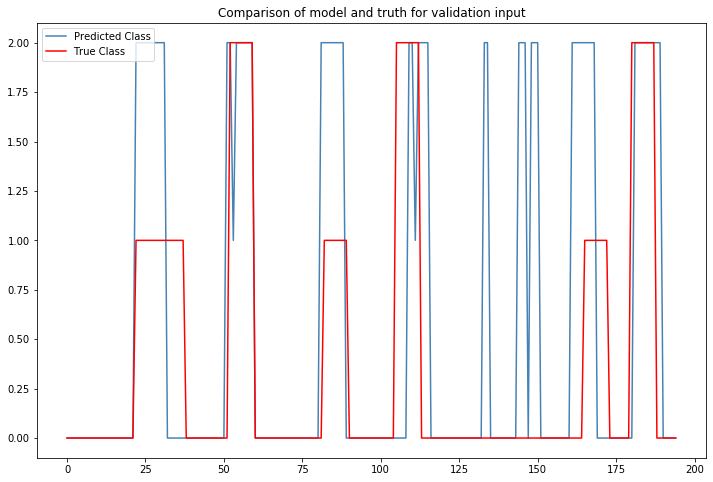

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(pred_final, color='steelblue')
ax.plot(label_final, color='red')
plt.title('Comparison of model and truth for validation input')
plt.legend(['Predicted Class','True Class'])
plt.show()

It's clear that the model is struggling to predict leaving vs entering. Overall, a good start, need more data

## Still a little bit of underfitting
- Areas for improvment
    - More diverse dataset 
    - Hyperparameter tuning
    - Make video window overlapping
    - ~~How to freeze some layers?~~ (2020-03-13)